In [125]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

plt.style.use('dark_background')

In [126]:
X, y = load_diabetes(return_X_y=True, as_frame=True)
X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


In [127]:
y

0      151.0
1       75.0
2      141.0
3      206.0
4      135.0
       ...  
437    178.0
438    104.0
439    132.0
440    220.0
441     57.0
Name: target, Length: 442, dtype: float64

### Gradient boosting machine (GBM)

#### 1 tree

In [128]:
# learning tree 1
tree1 = DecisionTreeRegressor(max_depth=3, random_state=2)
tree1.fit(X, y)

DecisionTreeRegressor(max_depth=3, random_state=2)

In [129]:
# prediction 1
prediction1 = tree1.predict(X)
R2 = r2_score(y, prediction1)
R2

0.5006720154703376

In [130]:
# residual 1
residual1 = y - prediction1
y[2], prediction1[2], residual1[2]

(141.0, 208.57142857142858, -67.57142857142858)

#### 2 tree

In [131]:
# learning tree 2
tree2 = DecisionTreeRegressor(max_depth=3, random_state=2)
tree2.fit(X, residual1)

DecisionTreeRegressor(max_depth=3, random_state=2)

In [132]:
# prediction 2
prediction2 = tree1.predict(X) + tree2.predict(X)

# summing of trees predictions 1 & 2
R2 = r2_score(y, prediction2)
R2

0.5785866108916171

In [133]:
# residual 2
residual2 = y - prediction2
y[2], prediction2[2], residual2[2]

(141.0, 207.5052553799773, -66.50525537997731)

#### tree 3

In [134]:
# learning tree 3
tree3 = DecisionTreeRegressor(max_depth=3, random_state=2)
tree3.fit(X, residual2)

DecisionTreeRegressor(max_depth=3, random_state=2)

In [135]:
# prediction 3
prediction3 = tree1.predict(X) + tree2.predict(X) + tree3.predict(X)

R2 = r2_score(y, prediction3)
R2

0.6271203539706915

In [136]:
# residual 3
residual3 = y - prediction3
y[2], prediction3[2], residual3[2]

(141.0, 174.76070684814292, -33.76070684814292)

### Gradient boosting machine (GBR)

In [137]:
from sklearn.model_selection import train_test_split

In [138]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [140]:
def gb_predict(X, trees_list, eta):
    # Variant 1
    predictions = np.zeros(X.shape[0])  # [0, 0... x100]
    for i, x in enumerate(X):  # x -> 1 data-object with 10 features
        prediction = 0
        for alg in trees_list:  # alg -> 1 basic algorithm
            prediction += eta * alg.predict([x])[0]  # eta * b(x)

        predictions[i] = prediction

    # Variant 2
    # predictions = np.array(
    #     [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    # )

    return predictions

In [141]:
# error functionality
def mean_square_error(y, predicted):
    return np.mean((y - predicted)**2)

In [142]:
# L2' loss
def residual(y, z):
    return - (z - y)

In [143]:
# learning GBM
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):

    # future list of trees
    trees = []

    # future list of (train, test) errors
    train_errors = []
    test_errors = []
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        if len(trees) == 0:
            tree.fit(X_train, y_train)

            train_errors.append(mean_square_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_square_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # answers for current composition
            target = gb_predict(X_train, trees, eta)
            tree.fit(X_train, residual(y_train, target))

            train_errors.append(mean_square_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_square_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)

    return trees, train_errors, test_errors

In [144]:
# Examples
n_trees = 10
max_depth = 3
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

In [145]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Number of trees {n_trees}, max depth: {max_depth}, \
with step: {eta}, error in train: {mean_square_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Number of trees {n_trees}, max depth: {max_depth}, \
with step: {eta}, error in test: {mean_square_error(y_test, test_prediction)}')

In [146]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Number of trees 10, max depth: 3, with step: 1, error in train: 1091.3133470640294
Number of trees 10, max depth: 3, with step: 1, error in test: 5638.040732905227


In [147]:
# build graphs
def get_error_plot(n_trees, train_error, test_error):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_error, label='train error')
    plt.plot(list(range(n_trees)), test_error, label='train error')
    plt.legend(loc='upper right')
    plt.show()

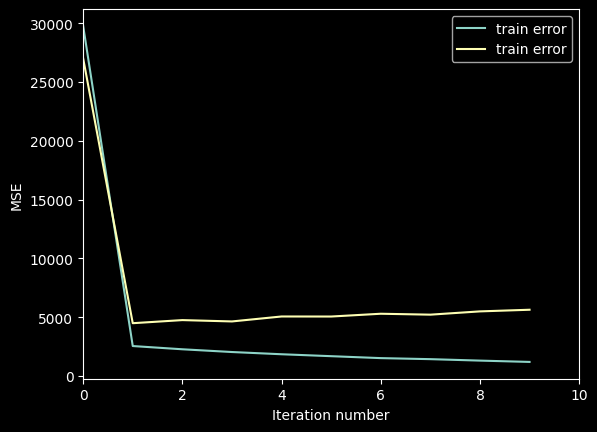

In [148]:
get_error_plot(n_trees, train_errors, test_errors)

Number of trees 50, max depth: 3, with step: 1, error in train: 46.987262015456835
Number of trees 50, max depth: 3, with step: 1, error in test: 6658.624829222572


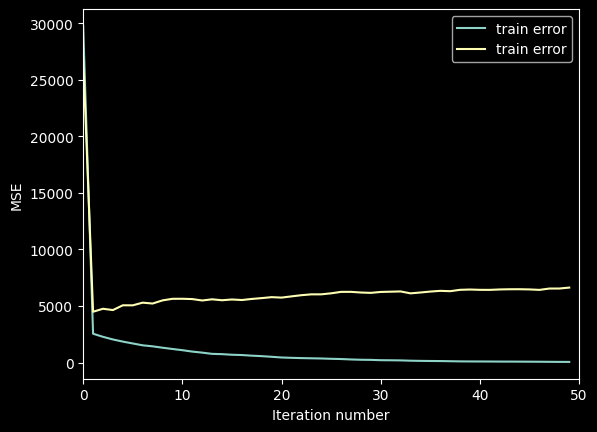

In [149]:
n_trees = 50
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
get_error_plot(n_trees, train_errors, test_errors)

Number of trees 50, max depth: 3, with step: 0.1, error in train: 1335.1474754274975
Number of trees 50, max depth: 3, with step: 0.1, error in test: 3676.470805873504


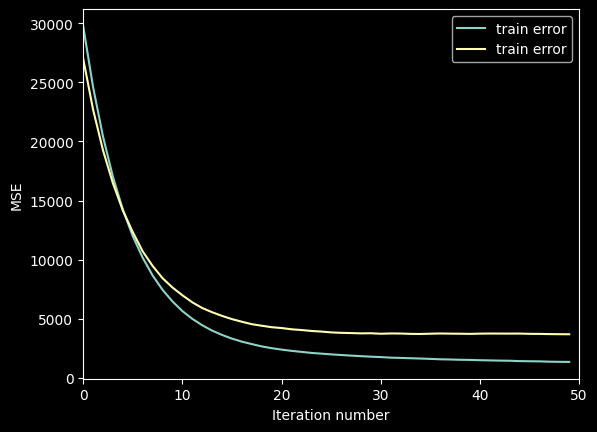

In [150]:
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
get_error_plot(n_trees, train_errors, test_errors)

Number of trees 50, max depth: 3, with step: 0.01, error in train: 12456.215480529923
Number of trees 50, max depth: 3, with step: 0.01, error in test: 12669.525727394088


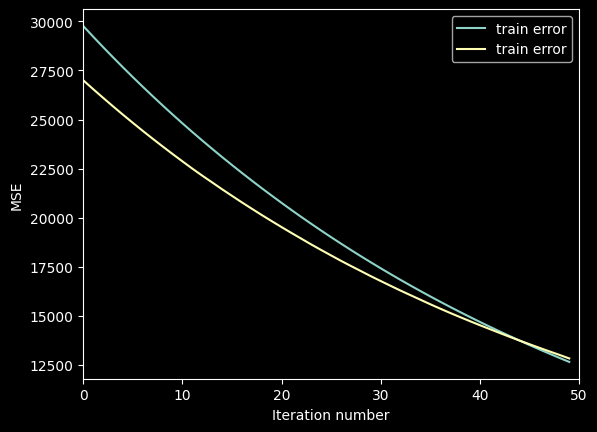

In [151]:
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
get_error_plot(n_trees, train_errors, test_errors)

Number of trees 50, max depth: 5, with step: 0.1, error in train: 289.44493885379865
Number of trees 50, max depth: 5, with step: 0.1, error in test: 4281.737546297548


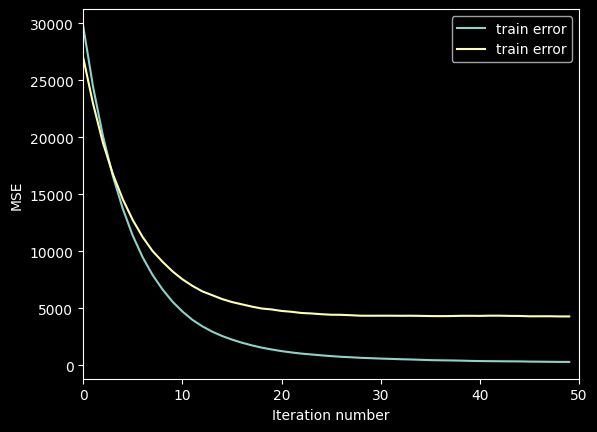

In [152]:
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
get_error_plot(n_trees, train_errors, test_errors)

#### Adaboost

In [153]:
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

In [154]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X.shape, y.shape

((569, 30), (569,))

In [155]:
np.random.seed(6)

index = np.random.randint(0, X.shape[0], 1)
X_test = X.loc[index]
y_test = y.loc[index]
X.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [156]:
X = X.loc[[ 41,  44,  73,  81,  89,  91, 135, 146, 484, 491]]
y = y.loc[[ 41,  44,  73,  81,  89,  91, 135, 146, 484, 491]]
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
41,10.95,21.35,71.90,371.1,0.12270,0.12180,0.10440,0.05669,0.1895,0.06870,...,12.84,35.34,87.22,514.0,0.19090,0.26980,0.4023,0.14240,0.2964,0.09606
44,13.17,21.81,85.42,531.5,0.09714,0.10470,0.08259,0.05252,0.1746,0.06177,...,16.23,29.89,105.50,740.7,0.15030,0.39040,0.3728,0.16070,0.3693,0.09618
73,13.80,15.79,90.43,584.1,0.10070,0.12800,0.07789,0.05069,0.1662,0.06566,...,16.57,20.86,110.30,812.4,0.14110,0.35420,0.2779,0.13830,0.2589,0.10300
81,13.34,15.86,86.49,520.0,0.10780,0.15350,0.11690,0.06987,0.1942,0.06902,...,15.53,23.19,96.66,614.9,0.15360,0.47910,0.4858,0.17080,0.3527,0.10160
89,14.64,15.24,95.77,651.9,0.11320,0.13390,0.09966,0.07064,0.2116,0.06346,...,16.34,18.24,109.40,803.6,0.12770,0.30890,0.2604,0.13970,0.3151,0.08473
91,15.37,22.76,100.20,728.2,0.09200,0.10360,0.11220,0.07483,0.1717,0.06097,...,16.43,25.84,107.50,830.9,0.12570,0.19970,0.2846,0.14760,0.2556,0.06828
135,12.77,22.47,81.72,506.3,0.09055,0.05761,0.04711,0.02704,0.1585,0.06065,...,14.49,33.37,92.04,653.6,0.14190,0.15230,0.2177,0.09331,0.2829,0.08067
146,11.80,16.58,78.99,432.0,0.10910,0.17000,0.16590,0.07415,0.2678,0.07371,...,13.74,26.38,91.93,591.7,0.13850,0.40920,0.4504,0.18650,0.5774,0.10300
484,15.73,11.28,102.80,747.2,0.10430,0.12990,0.11910,0.06211,0.1784,0.06259,...,17.01,14.20,112.50,854.3,0.15410,0.29790,0.4004,0.14520,0.2557,0.08181
491,17.85,13.23,114.60,992.1,0.07838,0.06217,0.04445,0.04178,0.1220,0.05243,...,19.82,18.42,127.10,1210.0,0.09862,0.09976,0.1048,0.08341,0.1783,0.05871


In [157]:
y

41     0
44     0
73     0
81     1
89     1
91     0
135    0
146    0
484    1
491    1
Name: target, dtype: int32

In [158]:
n_objects = X.shape[0]
w = np.ones(n_objects)
display(w)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

[Text(0.5, 0.75, 'mean texture <= 16.22\ngini = 0.48\nsamples = 10\nvalue = [6, 4]'),
 Text(0.25, 0.25, 'gini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]')]

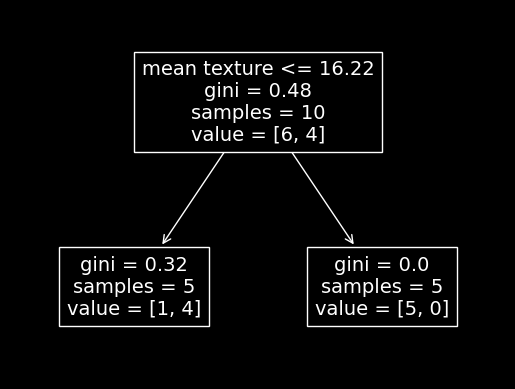

In [159]:
stump1 = DecisionTreeClassifier(max_depth=1, random_state=1)
stump1.fit(X, y, sample_weight=w)

pred = stump1.predict(X)
plot_tree(stump1, feature_names=X.columns)

In [160]:
pred == y

41      True
44      True
73     False
81      True
89      True
91      True
135     True
146     True
484     True
491     True
Name: target, dtype: bool

In [161]:
error1 = sum(pred != y) / len(pred)
error1

0.1

In [162]:
def amount_of_say(x):
    return 1/2 * np.log((1-x) / x)

C:\Users\grayni\AppData\Local\Temp\ipykernel_940\1977356716.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/2 * np.log((1-x) / x)
C:\Users\grayni\AppData\Local\Temp\ipykernel_940\1977356716.py:2: RuntimeWarning: divide by zero encountered in log
  return 1/2 * np.log((1-x) / x)


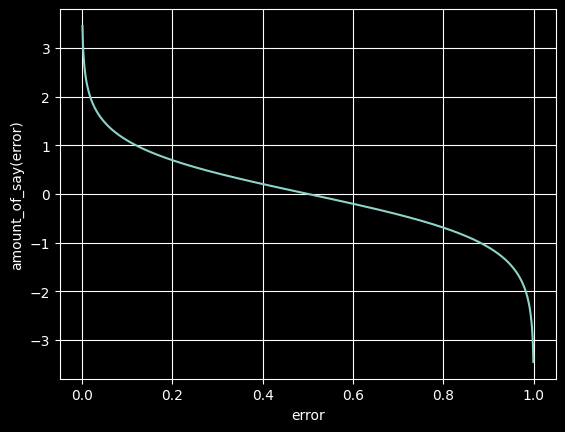

In [163]:
dots = np.linspace(0, 1, 1000)
amount_of_say_value = list(map(amount_of_say, dots))

plt.xlabel('error')
plt.ylabel('amount_of_say(error)')
plt.grid()
plt.plot(dots, amount_of_say_value)
plt.show()

In [164]:
alpha1 = 1/2 * np.log((1 - error1) / error1)
alpha1

1.0986122886681098

In [165]:
def new_sample_weight(x):
    return np.exp(x)

In [166]:
0.1 * np.exp(3.5)

3.3115451958692312

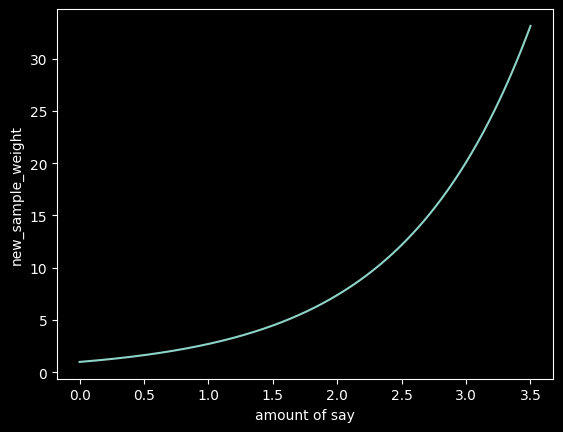

In [167]:
dots = np.linspace(0, 3.5, 1000)
new_sample_weight_value = list(map(new_sample_weight, dots))
plt.xlabel('amount of say')
plt.ylabel('new_sample_weight')
plt.plot(dots, new_sample_weight_value)
plt.show()

In [168]:
wrong_mask = pred != y
w[wrong_mask] *= np.exp(alpha1)
display(w)

array([1., 1., 3., 1., 1., 1., 1., 1., 1., 1.])

In [169]:
def new_sample_weight(x):
    return np.exp(-x)

In [170]:
0.1 * np.exp(-3.5)

0.00301973834223185

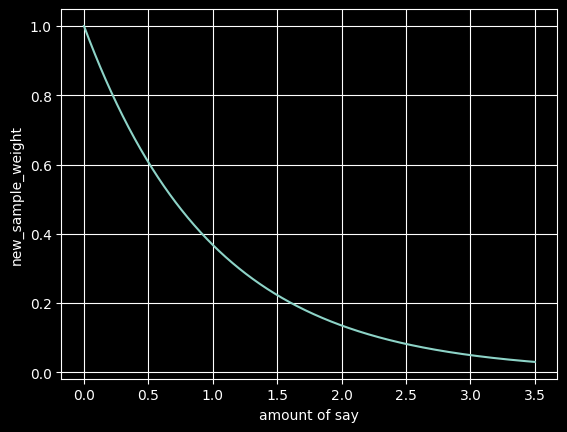

In [171]:
dots = np.linspace(0, 3.5, 1000)
new_sample_weight_value = list(map(new_sample_weight, dots))

plt.xlabel('amount of say')
plt.ylabel('new_sample_weight')
plt.grid()
plt.plot(dots, new_sample_weight_value)
plt.show()

In [172]:
w[~wrong_mask] *= np.exp(-alpha1)
display(w)

array([0.33333333, 0.33333333, 3.        , 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333])

In [173]:
sum(w)

5.999999999999998

In [174]:
w /= sum(w)
display(w)

array([0.05555556, 0.05555556, 0.5       , 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556])

In [175]:
sum(w)

1.0000000000000004

[Text(0.5, 0.75, 'mean texture <= 15.515\ngini = 0.346\nsamples = 10\nvalue = [0.778, 0.222]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0.0, 0.167]'),
 Text(0.75, 0.25, 'gini = 0.124\nsamples = 7\nvalue = [0.778, 0.056]')]

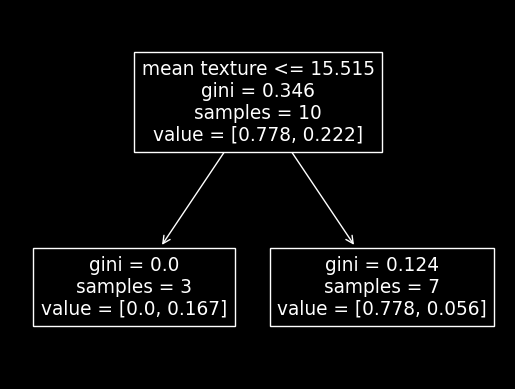

In [176]:
# stump2
stump2 = DecisionTreeClassifier(max_depth=1, random_state=1)
stump2.fit(X, y, sample_weight=w)

pred = stump2.predict(X)
plot_tree(stump2, feature_names=X.columns)

In [177]:
display(pred != y)

41     False
44     False
73     False
81      True
89     False
91     False
135    False
146    False
484    False
491    False
Name: target, dtype: bool

In [178]:
error2 = sum(pred != y) / len(y)
alpha2 = 1/2 * np.log((1 - error2) / error2)

wrong_mask = pred != y
w[wrong_mask] *= np.exp(alpha2)

w[~wrong_mask] *= np.exp(-alpha2)

w /= sum(w)
display(w)

array([0.03846154, 0.03846154, 0.34615385, 0.34615385, 0.03846154,
       0.03846154, 0.03846154, 0.03846154, 0.03846154, 0.03846154])

In [179]:
stump3 = DecisionTreeClassifier(max_depth=1, random_state=1)
stump3.fit(X, y, sample_weight=w)

pred = stump3.predict(X)
error3 = sum(pred != y) / len(y)
alpha3 = 1/2 * np.log((1 - error3) / error3)

wrong_mask = pred != y
w[wrong_mask] = w[wrong_mask] * np.exp(alpha3)

w[~wrong_mask] = w[~wrong_mask] * np.exp(-alpha3)
w /= sum(w)
display(w)

array([0.03125, 0.03125, 0.28125, 0.28125, 0.125  , 0.03125, 0.03125,
       0.03125, 0.03125, 0.125  ])

In [180]:
display(X_test, y_test)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
227,15.0,15.51,97.45,684.5,0.08371,0.1096,0.06505,0.0378,0.1881,0.05907,...,16.41,19.31,114.2,808.2,0.1136,0.3627,0.3402,0.1379,0.2954,0.08362


227    1
Name: target, dtype: int32

In [181]:
alpha1, alpha2, alpha3

(1.0986122886681098, 1.0986122886681098, 0.6931471805599453)

In [182]:
pred1 = stump1.predict(X_test)
pred2 = stump2.predict(X_test)
pred3 = stump3.predict(X_test)
pred1, pred2, pred3

(array([1]), array([1]), array([0]))

In [183]:
alpha1 + alpha2, alpha3

(2.1972245773362196, 0.6931471805599453)

In [184]:
pred = 1
y_test

227    1
Name: target, dtype: int32

### Realization AdaBoost

In [205]:
X, y = load_breast_cancer(return_X_y=True)
display(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)

(569, 30)

(569,)

In [206]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

In [207]:
def adaboost(X, y, N):
    n_objects = len(X)
    n_classes = len(np.unique(y))
    w = np.ones(n_objects) / n_objects
    models = []

    for n in range(N):
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        error = get_error(predictions, y)

        if error >= 1 - 1 / n_classes:  # if error > 0.5
            continue

        if error == 0:
            error += 1e-10

        alpha = 0.5 * np.log((1 - error) / error)

        wrong_mask = predictions != y

        w[wrong_mask] *= np.exp(alpha)
        w[~wrong_mask] *= np.exp(-alpha)

        w /= w.sum()

        models.append((alpha, clf))

    return models

In [208]:
N = 50

models = adaboost(X_train, y_train, N)

In [209]:
np.zeros((10, 2))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [210]:
def predict(X, models):
    n_classes = 2
    n_objects = len(X)

    y_pred = np.zeros((n_objects, n_classes))

    for alpha, clf in models:
        prediction = clf.predict(X)
        y_pred[range(n_objects), prediction] += alpha

    y_pred = np.argmax(y_pred, axis=1)

    return y_pred

In [211]:
print(f'{(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')

96.948


In [212]:
print(f'{(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

94.406


In [213]:
train_errors = []
test_errors = []

for n in range(1, 31):
    models = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, models), y_train))
    test_errors.append(get_error(predict(X_test, models), y_test))

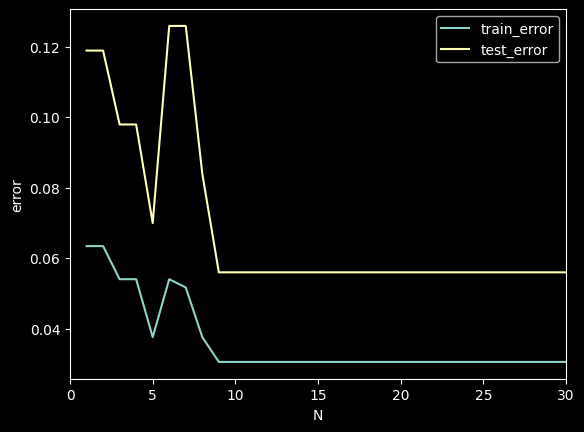

In [214]:
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train_error')
plt.plot(x, test_errors, label='test_error')
plt.xlabel('N')
plt.ylabel('error')
plt.legend(loc='upper right')
plt.show()